## Graph 1

#### Firstly, open the path in where the file is located

Successfully loaded the Excel file.
Columns found: ['Hectares', 'Census', 'Total', 'With technical orientation', 'Public', 'Proper', 'Other']


C:\Users\daves\AppData\Local\Temp\ipykernel_22340\2403005834.py:93: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_positions = df.groupby('Census').apply(lambda x: x.index.min() + (x.index.max() - x.index.min()) / 2)


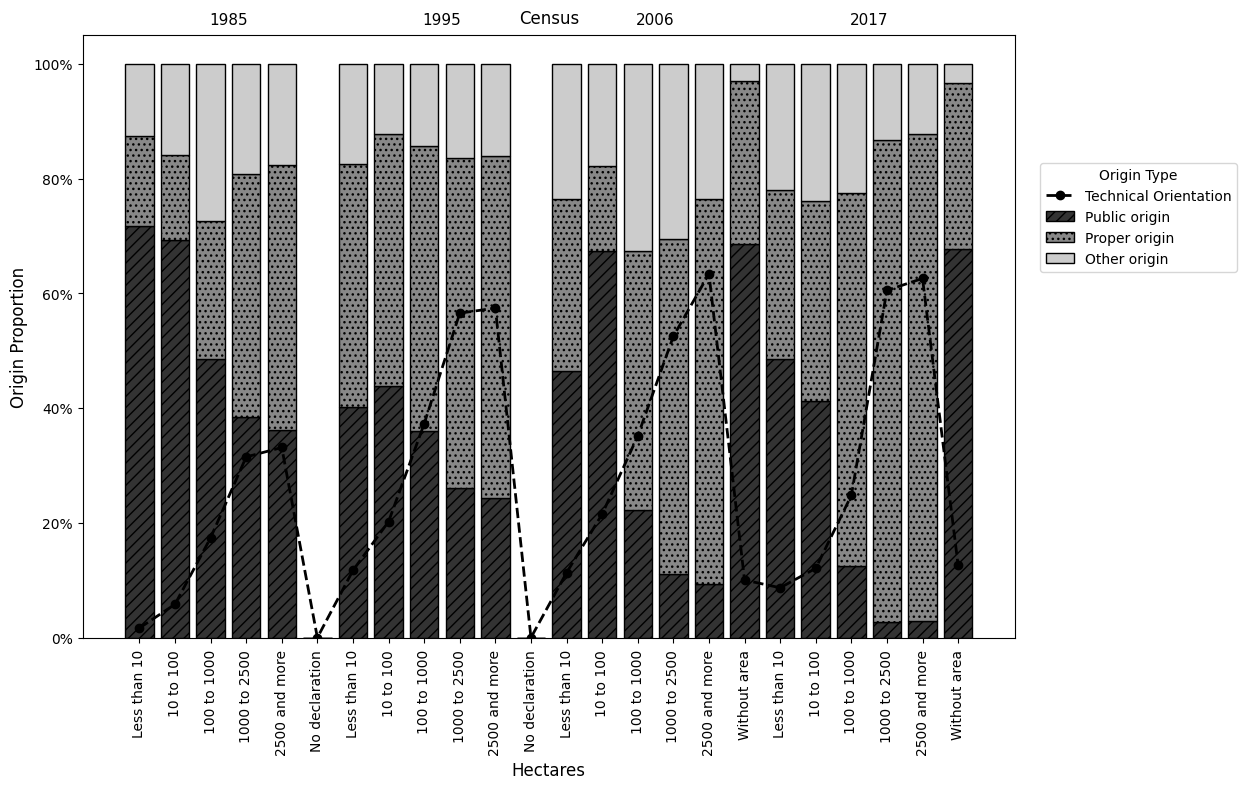

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# 1. Load the data directly from your Excel file
try:
    file_path = 'Technical Orientation.xlsx'
    sheet_name = 'Final Values'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    print("Successfully loaded the Excel file.")
    print(f"Columns found: {list(df.columns)}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure the Excel file is in the same directory as the script.")
    exit()

# 2. Perform Percentage Calculations
origin_cols = ['Public', 'Proper', 'Other']
# Calculate the sum of origin types for the denominator
origin_sum = df[origin_cols].sum(axis=1)

# Calculate the percentage for each origin type for the stacked bars
for col in origin_cols:
    # New column name for the percentage, e.g., 'Public_pct'
    pct_col_name = f'{col}_pct'
    # Calculate percentage, handling division by zero by filling resulting NaNs with 0
    df[pct_col_name] = (df[col] / origin_sum * 100).fillna(0)

# Calculate the percentage for the line plot ('With technical orientation' vs 'Total')
# Handle division by zero by filling resulting NaNs with 0
df['Tech_orientation_pct'] = (df['With technical orientation'] / df['Total'] * 100).fillna(0)


# 3. Setup plot styles for black and white
colors = {'Public': '#333333', 'Proper': '#888888', 'Other': '#cccccc'}
hatches = {'Public': '///', 'Proper': '...', 'Other': ''}
line_color = 'black'

# Mapping for prettier legend labels
label_map = {
    'Public': 'Public origin',
    'Proper': 'Proper origin',
    'Other': 'Other origin'
}

fig, ax = plt.subplots(figsize=(14, 8))

# 4. Plot the stacked bar chart using the new percentage columns
bar_width = 0.8
bottom = np.zeros(len(df))

for origin_type in origin_cols:
    pct_col_name = f'{origin_type}_pct' # e.g., 'Public_pct'
    ax.bar(
        df.index,
        df[pct_col_name],
        width=bar_width,
        label=label_map[origin_type],
        bottom=bottom,
        color=colors[origin_type],
        hatch=hatches[origin_type],
        edgecolor='black'
    )
    # Add the height of the current bar to the bottom for the next one
    bottom += df[pct_col_name]

# 5. Plot the line graph using the new percentage column
ax.plot(
    df.index,
    df['Tech_orientation_pct'],
    label='Technical Orientation',
    color=line_color,
    marker='o',
    linestyle='--',
    linewidth=2
)

# 6. Customize the Axes and Labels
# Y-axis
ax.set_ylabel('Origin Proportion', fontsize=12)
ax.yaxis.set_major_formatter(mticker.PercentFormatter()) # No '100' needed, as data is already 0-100
ax.set_ylim(0, 105)

# X-axis
ax.set_xlabel('Hectares', fontsize=12)
ax.set_xticks(df.index)
ax.set_xticklabels(df['Hectares'], rotation=90)
ax.tick_params(axis='x', which='major', pad=5)

# Add top labels for Census Year
ax.text(0.5, 1.02, 'Census', transform=ax.transAxes, ha='center', fontsize=12)
year_positions = df.groupby('Census').apply(lambda x: x.index.min() + (x.index.max() - x.index.min()) / 2)
for year, pos in year_positions.items():
    ax.text(pos, 107, year, ha='center', fontsize=11)

# 7. Add Legend and Final Touches
ax.legend(title='Origin Type', bbox_to_anchor=(1.02, 0.8), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.grid(False)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Save the figure and show the plot
plt.savefig('Graph1.jpg', dpi=1200)
plt.show()


## Graph 2

C:\Users\daves\AppData\Local\Temp\ipykernel_22340\796460411.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_geometries_series = filtered_highways_MT.groupby('vl_br').apply(combine_geometries)


Marker placement summary:
BR-070: 17 markers across 35 segments
BR-080: 3 markers across 2 segments
BR-158: 20 markers across 29 segments
BR-163: 21 markers across 51 segments
BR-174: 27 markers across 29 segments
BR-242: 17 markers across 19 segments
BR-251: 12 markers across 16 segments
BR-364: 26 markers across 48 segments


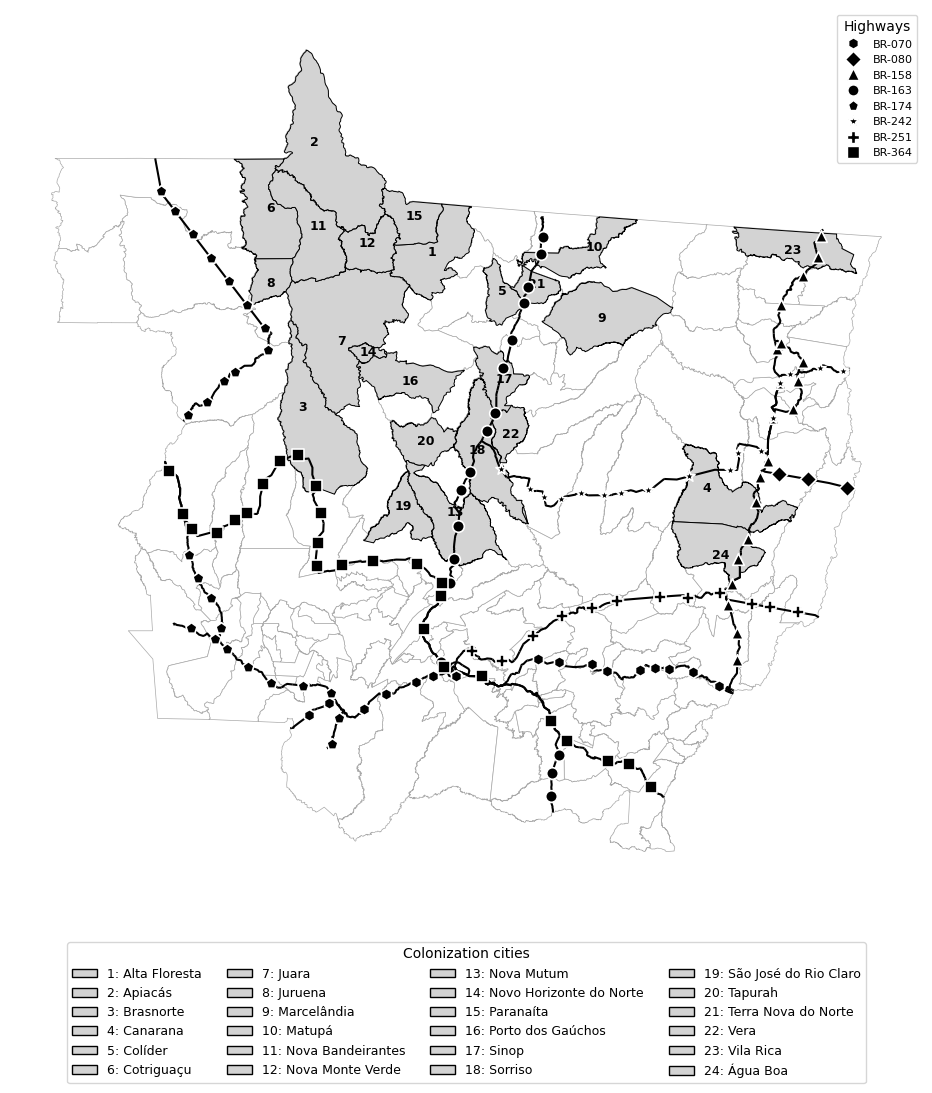

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import LineString, MultiLineString, Point

# --- 1. Load Data ---
# Ensure the file paths below are correct for your system.

# Municipalities Shapefile
shapefile_path_municipalities = r"MT_Municipios_2022\MT_Municipios_2022.shp"
municipalities = gpd.read_file(shapefile_path_municipalities)

# Highways Shapefile
shapefile_path_highways = r"Rodovias\SNV_202410A.shp"
highways = gpd.read_file(shapefile_path_highways)

# Colonization Data from Excel
file_path_excel = "Table 1.xlsx"
colonization = pd.read_excel(file_path_excel, sheet_name='Planilha1')


# --- 2. Process and Merge Data ---

# Filter highways for Mato Grosso (MT)
filtered_highways_MT = highways[highways['sg_uf'] == 'MT']

# Group highways by their BR number and combine their geometries
def combine_geometries(group):
    return unary_union(group.geometry)

combined_geometries_series = filtered_highways_MT.groupby('vl_br').apply(combine_geometries)
combined_geometries = gpd.GeoDataFrame(geometry=combined_geometries_series.values, crs=filtered_highways_MT.crs)
combined_geometries['vl_br'] = combined_geometries_series.index

# Join municipal data with colonization data
merged = pd.merge(municipalities, colonization, left_on='NM_MUN', right_on='City', how='inner')

# Filter for cities that have a valid colonization year
colonization_cities = merged[merged['Year'].notna()].copy()


# --- 3. Function to normalize angle (keep text readable) ---
def normalize_angle(angle):
    """Normalize angle to keep text readable (not upside down)"""
    angle = angle % 360
    if angle > 90 and angle <= 270:
        angle = angle - 180
    return angle

# --- 4. Function to place markers at specific distance intervals ---
def get_distance_based_markers(highway_geom, marker_distance=0.5, start_offset=0.2, min_segment_length=0.01):
    """
    Place markers at specific distance intervals along highway geometry
    
    Parameters:
    highway_geom: shapely geometry (LineString or MultiLineString)
    marker_distance: physical distance between markers in the same units as the geometry
    start_offset: distance from start of each segment before placing first marker
    min_segment_length: minimum length threshold for segments to be considered
    
    Returns:
    List of (x, y, angle) tuples for marker positions
    """
    positions = []
    
    def calculate_angle_at_distance(line, distance):
        """Calculate angle at a specific distance along a line"""
        # Calculate a small segment around the point for angle calculation
        angle_calc_distance = min(0.01, line.length * 0.05)  # 1% of line length or 0.01 units
        
        prev_distance = max(0, distance - angle_calc_distance)
        next_distance = min(line.length, distance + angle_calc_distance)
        
        try:
            p1 = line.interpolate(prev_distance)
            p2 = line.interpolate(next_distance)
            return normalize_angle(np.degrees(np.arctan2(p2.y - p1.y, p2.x - p1.x)))
        except:
            return 0
    
    def process_line_segment(line, start_offset, marker_distance):
        """Process a single LineString to place markers at distance intervals"""
        line_positions = []
        
        if line.length < min_segment_length:
            return line_positions
        
        # Start placing markers after the start offset
        current_distance = start_offset
        
        # Place markers at regular distance intervals
        while current_distance < (line.length - start_offset):
            try:
                # Get point at current distance
                point = line.interpolate(current_distance)
                
                # Calculate angle at this point
                angle = calculate_angle_at_distance(line, current_distance)
                
                line_positions.append((point.x, point.y, angle))
                
                # Move to next marker position
                current_distance += marker_distance
                
            except Exception as e:
                # Skip this point if there's an error
                current_distance += marker_distance
                continue
        
        return line_positions
    
    if isinstance(highway_geom, MultiLineString):
        # Handle MultiLineString: process each significant segment
        lines = list(highway_geom.geoms)
        
        # Filter and sort segments by length (longest first)
        significant_lines = [line for line in lines if line.length > min_segment_length]
        significant_lines.sort(key=lambda x: x.length, reverse=True)
        
        for line in significant_lines:
            line_positions = process_line_segment(line, start_offset, marker_distance)
            positions.extend(line_positions)
            
    else:
        # Handle single LineString
        positions = process_line_segment(highway_geom, start_offset, marker_distance)
    
    return positions

# --- 5. Plotting the Map ---

fig, ax = plt.subplots(figsize=(12, 14))

# Plot the base map of all municipalities
municipalities.plot(ax=ax, color="white", edgecolor='darkgray', linewidth=0.5)

# --- 6. Plot Highways ---
combined_geometries.plot(ax=ax, color='black', linestyle='-', linewidth=1.5)

# --- 7. Add Distance-Based Highway Markers ---

# Define markers for each highway
highway_markers = {
    '163': 'o',    # Circle
    '364': 's',    # Square
    '158': '^',    # Triangle up
    '070': 'h',    # Hexagon
    '080': 'D',    # Diamond
    '174': 'p',    # Pentagon
    '242': '*',    # Star
    '251': 'P',    # Plus (filled)
}

# DISTANCE PARAMETERS (adjust these to control marker spacing)
# Note: These values depend on your coordinate system units
# For geographic coordinates (degrees), use smaller values like 0.2-0.5
# For projected coordinates (meters), use larger values like 50000-100000
MARKER_DISTANCE = 0.4      # Distance between markers (in coordinate system units)
START_OFFSET = 0.1         # Distance from start/end of segments before first/last marker
MIN_SEGMENT_LENGTH = 0.05  # Minimum segment length to consider

# Create legend elements for highways
legend_elements_highways = []

unique_highways = sorted(combined_geometries['vl_br'].unique())
for br_name in unique_highways:
    highway_geom = combined_geometries[combined_geometries['vl_br'] == br_name].geometry.iloc[0]
    
    # Get marker for this highway (default to circle if not specified)
    marker = highway_markers.get(str(br_name), 'o')
    
    # Get markers at specific distance intervals
    positions = get_distance_based_markers(
        highway_geom, 
        marker_distance=MARKER_DISTANCE,
        start_offset=START_OFFSET,
        min_segment_length=MIN_SEGMENT_LENGTH
    )
    
    # Plot markers at each position
    for x, y, angle in positions:
        ax.scatter(x, y, marker=marker, s=70, c='black', edgecolors='white', 
                  linewidth=1.2, zorder=5)
    
    # Add to legend (only once per highway)
    legend_elements_highways.append(
        Line2D([0], [0], marker=marker, color='w', markerfacecolor='black', 
               markeredgecolor='white', markersize=8, label=f'BR-{br_name}')
    )

# Print marker count information for debugging
print("Marker placement summary:")
for br_name in unique_highways:
    highway_geom = combined_geometries[combined_geometries['vl_br'] == br_name].geometry.iloc[0]
    positions = get_distance_based_markers(
        highway_geom, 
        marker_distance=MARKER_DISTANCE,
        start_offset=START_OFFSET,
        min_segment_length=MIN_SEGMENT_LENGTH
    )
    if isinstance(highway_geom, MultiLineString):
        segments = len([line for line in highway_geom.geoms if line.length > MIN_SEGMENT_LENGTH])
        print(f"BR-{br_name}: {len(positions)} markers across {segments} segments")
    else:
        print(f"BR-{br_name}: {len(positions)} markers on single segment")

# --- 8. Plot, Number, and Create Legend for Cities ---

legend_elements_colonization = []
# Sort cities alphabetically to ensure consistent numbering
sorted_cities = sorted(colonization_cities['NM_MUN'].unique())

for i, city_name in enumerate(sorted_cities):
    city_geo = colonization_cities[colonization_cities['NM_MUN'] == city_name]

    # Plot the city polygon
    city_geo.plot(ax=ax, facecolor='#d3d3d3', edgecolor='black', linewidth=0.7)

    # Find a safe point for the label (representative_point is better than centroid)
    label_pos = city_geo.geometry.iloc[0].representative_point()

    # Add the number label to the city
    ax.text(label_pos.x, label_pos.y, str(i + 1),
            ha='center', va='center', fontsize=9, weight='bold', color='black')

    # Create a corresponding legend entry
    legend_elements_colonization.append(
        Patch(facecolor='#d3d3d3', edgecolor='black', label=f"{i+1}: {city_name}")
    )

# Create the legend for Highways
highway_legend = ax.legend(
    handles=legend_elements_highways,
    title="Highways",
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0),
    prop={'size': 8},
    fancybox=True
)

# Create the legend for Colonization Cities
city_legend = ax.legend(
    handles=legend_elements_colonization,
    title="Colonization cities",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05), # Position below the plot
    ncol=4, # Adjust columns as needed
    prop={'size': 9},
    fancybox=True
)

# Add the highway legend back to the plot
ax.add_artist(highway_legend)


# --- 9. Final Touches ---

# Clean up the plot appearance
ax.set_axis_off()
fig.subplots_adjust(bottom=0.25) # Make more room for the longer legend

# Save the figure
output_path = "Graph_2.jpg"
plt.savefig(output_path, dpi=1200, bbox_inches='tight')

# Display the plot
plt.show()